In [69]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr,kendalltau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.constants import R, kilo
from typing import Tuple
import os

In [18]:
def pkd_to_dg(
    pkd: float,
    uncertainty: float,
    temperature: float = 298.15
) -> Tuple[float, float]:
    """
    Convert the pKd value and its uncertainty to ΔG.

    Args:
        pkd: The pKd value.
        uncertainty: The standard deviation in the pKd value.
        temperature: Experimental temperature in Kelvin. Default: 298.15 K.

    Returns:
        dg: Gibbs binding free energy in kilocalories per mole.
        ddg: Error in binding free energy in kilocalories per mole.
    """
    # Convert pKd to Kd (dissociation constant in molar)
    kd = 10 ** (-pkd)  # Convert to molar from nM 
    
    # Calculate ΔG
    dg = R * temperature * np.log(kd) / kilo  # Convert J to kJ, then to kcal (1 kcal = 4184 J)
    dg_kcal_per_mol = dg / 4.184  # Convert kJ to kcal

    # Calculate the uncertainty in ΔG
    ddg = R * temperature * np.log(10) * uncertainty / kilo
    ddg_kcal_per_mol = ddg / 4.184  # Convert kJ to kcal

    return dg_kcal_per_mol,ddg_kcal_per_mol

def fisher_transformation(r):
    """Apply Fisher transformation for correlation coefficient."""
    return 0.5 * np.log((1 + r) / (1 - r))

def inverse_fisher_transformation(z):
    """Convert Fisher transformed value back to correlation coefficient."""
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)



In [21]:
# Load data
file_path = 'data/BALM+Docking_data.csv'
data = pd.read_csv(file_path)

uncertainty_value = 0.1
data['label_dG'] = data.apply(lambda row: pkd_to_dg(row['Y'],uncertainty_value)[0], axis=1)
#data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], uncertainty_value)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pkd_to_dg(row['prediction'], uncertainty_value)[0], axis=1)
data['vina_dG'] = data['vina dGbind']
data['rdock_dG'] = data['rdock SCORE'] / 4.2  

# Filter out NaN values for relevant columns
target_counts_type = data['type'].value_counts()
targets_to_plot_type = target_counts_type[target_counts_type >= 10].index
filtered_data = data[(data['type'].isin(targets_to_plot_type)) & (data['type'] != 'other')]
filtered_data = filtered_data.dropna(subset=['label_dG', 'prediction_dG', 'vina_dG', 'rdock_dG'])
# Calculate metrics for each target family
target_metrics = []
for target in filtered_data['type'].unique():
    target_data = filtered_data[filtered_data['type'] == target]

    # Fisher-transformed Pearson and Spearman for BALM, AutoDock, and rDock
    if len(target_data) > 1:
        pearson_balm, _ = pearsonr(target_data['label_dG'], target_data['prediction_dG'])
        spearman_balm, _ = spearmanr(target_data['label_dG'], target_data['prediction_dG'])
        rmse_balm = mean_squared_error(target_data['label_dG'], target_data['prediction_dG'], squared=False)

        pearson_vina, _ = pearsonr(target_data['label_dG'], target_data['vina_dG'])
        spearman_vina, _ = spearmanr(target_data['label_dG'], target_data['vina_dG'])
        rmse_vina = mean_squared_error(target_data['label_dG'], target_data['vina_dG'], squared=False)

        pearson_rdock, _ = pearsonr(target_data['label_dG'], target_data['rdock_dG'])
        spearman_rdock, _ = spearmanr(target_data['label_dG'], target_data['rdock_dG'])
        rmse_rdock = mean_squared_error(target_data['label_dG'], target_data['rdock_dG'], squared=False)

        # Fisher-transformed values
        fisher_pearson_balm = fisher_transformation(pearson_balm)
        fisher_pearson_vina = fisher_transformation(pearson_vina)
        fisher_pearson_rdock = fisher_transformation(pearson_rdock)

        fisher_spearman_balm = fisher_transformation(spearman_balm)
        fisher_spearman_vina = fisher_transformation(spearman_vina)
        fisher_spearman_rdock = fisher_transformation(spearman_rdock)

        target_metrics.append({
            "Target": target,
            "Pearson BALM": fisher_pearson_balm,
            "Pearson Vina": fisher_pearson_vina,
            "Pearson rDock": fisher_pearson_rdock,
            "Spearman BALM": fisher_spearman_balm,
            "Spearman Vina": fisher_spearman_vina,
            "Spearman rDock": fisher_spearman_rdock,
            "RMSE BALM": rmse_balm,
            "RMSE Vina": rmse_vina,
            "RMSE rDock": rmse_rdock
        })


metrics_df = pd.DataFrame(target_metrics)
metrics_df


,Target,Pearson BALM,Pearson Vina,Pearson rDock,Spearman BALM,Spearman Vina,Spearman rDock,RMSE BALM,RMSE Vina,RMSE rDock
0,isomerase,0.924410,0.859419,0.188292,0.762370,0.789910,-0.024565,2.003311,1.903007,3.448756
1,hydrolase,0.626815,0.586708,0.234751,0.582855,0.611980,0.348524,2.152919,2.860929,4.556696
2,chaperone,0.907334,0.773517,0.659508,0.657241,0.643615,0.531033,1.750935,1.944762,2.362961
3,lyase,0.421444,0.431585,0.359658,0.400606,0.424611,0.331986,2.836132,4.418499,4.738117
4,transcription,0.435317,0.415249,0.336086,0.434771,0.402417,0.345715,1.490314,2.027209,3.202893
5,transport,0.152486,0.255260,0.243665,0.179796,0.228905,0.250175,2.825413,4.337723,5.344193
6,transferase,0.782250,0.120188,-0.004088,0.769863,0.452590,0.053697,1.824663,6.223376,4.110826
7,oxidoreductase,0.663156,0.784715,0.584469,0.681767,0.787568,0.640055,1.731847,2.876238,2.714492
8,ligase,0.623777,0.699446,0.379415,0.642349,0.752122,0.310797,2.227826,2.104566,3.618657
9,membrane,0.442798,0.314232,0.158034,0.423074,0.369119,0.042621,2.109129,2.836589,4.437898


In [70]:
# Calculate metrics for each target family
target_metrics = []
for target in filtered_data['type'].unique():
    target_data = filtered_data[filtered_data['type'] == target]

    # Calculate metrics for BALM and Vina models
    if len(target_data) > 1:
        # Pearson, Spearman, Kendall, RMSE for BALM
        pearson_balm, _ = pearsonr(target_data['label_dG'], target_data['prediction_dG'])
        spearman_balm, _ = spearmanr(target_data['label_dG'], target_data['prediction_dG'])
        kendall_balm, _ = kendalltau(target_data['label_dG'], target_data['prediction_dG'])
        rmse_balm = mean_squared_error(target_data['label_dG'], target_data['prediction_dG'], squared=False)

        # Pearson, Spearman, Kendall, RMSE for Vina
        pearson_vina, _ = pearsonr(target_data['label_dG'], target_data['vina_dG'])
        spearman_vina, _ = spearmanr(target_data['label_dG'], target_data['vina_dG'])
        kendall_vina, _ = kendalltau(target_data['label_dG'], target_data['vina_dG'])
        rmse_vina = mean_squared_error(target_data['label_dG'], target_data['vina_dG'], squared=False)

        target_metrics.append({
            "Target": target,
            "Pearson BALM": pearson_balm,
            "Pearson Vina": pearson_vina,
            "Spearman BALM": spearman_balm,
            "Spearman Vina": spearman_vina,
            "Kendall BALM": kendall_balm,
            "Kendall Vina": kendall_vina,
            "RMSE BALM": rmse_balm,
            "RMSE Vina": rmse_vina
        })

# Convert to DataFrame and display
metrics_df1 = pd.DataFrame(target_metrics)
metrics_df1

,Target,Pearson BALM,Pearson Vina,Spearman BALM,Spearman Vina,Kendall BALM,Kendall Vina,RMSE BALM,RMSE Vina
0,isomerase,0.727977,0.695958,0.642471,0.658358,0.437942,0.459677,2.003311,1.903007
1,hydrolase,0.555855,0.527524,0.524738,0.545519,0.367375,0.388299,2.152919,2.860929
2,chaperone,0.719850,0.648970,0.576524,0.567356,0.415312,0.410352,1.750935,1.944762
3,lyase,0.398146,0.406645,0.380468,0.400808,0.257977,0.276950,2.836132,4.418499
4,transcription,0.409755,0.392921,0.409301,0.382015,0.278553,0.265637,1.490314,2.027209
5,transport,0.151315,0.249856,0.177883,0.224989,0.110268,0.138594,2.825413,4.337723
6,transferase,0.653996,0.119612,0.646850,0.424025,0.457429,0.294825,1.824663,6.223376
7,oxidoreductase,0.580460,0.655405,0.592667,0.657029,0.428196,0.478216,1.731847,2.876238
8,ligase,0.553752,0.604016,0.566497,0.636413,0.378331,0.458260,2.227826,2.104566
9,membrane,0.415961,0.304282,0.399517,0.353221,0.254446,0.250001,2.109129,2.836589


In [71]:
metrics_df1.to_csv('data/target_wise_metrics_Balm_Vina.csv')

In [66]:
metrics_df.to_csv('data/target_wise_fisher_metrics.csv')

In [62]:
# Aggregate Fisher means and standard deviations for Pearson and Spearman across target families
pearson_means = {
    'BALM': inverse_fisher_transformation(metrics_df['Pearson BALM'].mean()),
    'Vina': inverse_fisher_transformation(metrics_df['Pearson Vina'].mean()),
    'rDock': inverse_fisher_transformation(metrics_df['Pearson rDock'].mean())
}
pearson_stds = {
    'BALM': metrics_df['Pearson BALM'].std(),
    'Vina': metrics_df['Pearson Vina'].std(),
    'rDock': metrics_df['Pearson rDock'].std()
}

spearman_means = {
    'BALM': inverse_fisher_transformation(metrics_df['Spearman BALM'].mean()),
    'Vina': inverse_fisher_transformation(metrics_df['Spearman Vina'].mean()),
    'rDock': inverse_fisher_transformation(metrics_df['Spearman rDock'].mean())
}
spearman_stds = {
    'BALM': metrics_df['Spearman BALM'].std(),
    'Vina': metrics_df['Spearman Vina'].std(),
    'rDock': metrics_df['Spearman rDock'].std()
}

# RMSE mean and standard deviation
rmse_means = {
    'BALM': metrics_df['RMSE BALM'].mean(),
    'Vina': metrics_df['RMSE Vina'].mean(),
    'rDock': metrics_df['RMSE rDock'].mean()
}
rmse_stds = {
    'BALM': metrics_df['RMSE BALM'].std(),
    'Vina': metrics_df['RMSE Vina'].std(),
    'rDock': metrics_df['RMSE rDock'].std()
}

# Ready data for plotting
plot_data = pd.DataFrame({
    'Model': ['BALM', 'Vina', 'rDock'],
    'Pearson': [pearson_means['BALM'], pearson_means['Vina'], pearson_means['rDock']],
    'Pearson Std': [pearson_stds['BALM'], pearson_stds['Vina'], pearson_stds['rDock']],
    'Spearman': [spearman_means['BALM'], spearman_means['Vina'], spearman_means['rDock']],
    'Spearman Std': [spearman_stds['BALM'], spearman_stds['Vina'], spearman_stds['rDock']],
    'RMSE': [rmse_means['BALM'], rmse_means['Vina'], rmse_means['rDock']],
    'RMSE Std': [rmse_stds['BALM'], rmse_stds['Vina'], rmse_stds['rDock']]
})




In [55]:
# Define colors 
vina_alpha = 0.8  
rdock_alpha = 0.7
balm_color = sns.color_palette([(0.4, 0.4, 0.7)])[0]
vina_color = (1, 0.5, 0, vina_alpha) 
rdock_color = (1, 0.5, 0, rdock_alpha) 
colors = [balm_color, vina_color, rdock_color]
bar_width=0.7

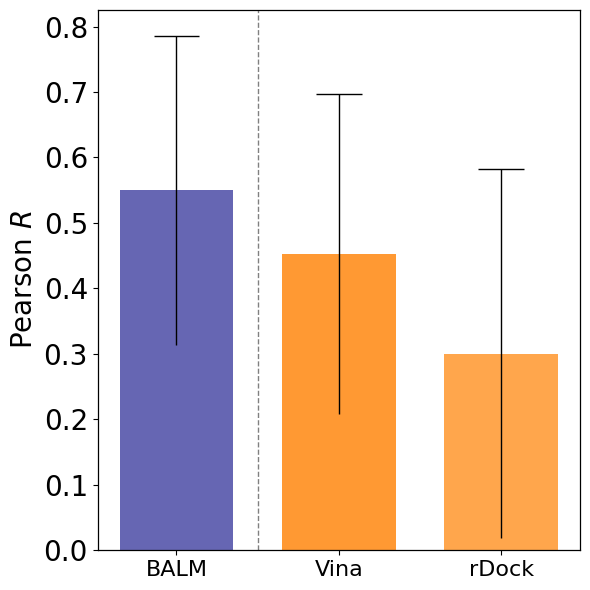

In [63]:
# Plot Pearson
plt.figure(figsize=(6,6))
bars = plt.bar(plot_data['Model'], plot_data['Pearson'], color=colors, width=bar_width)

# Set y-axis label
plt.ylabel(r'Pearson $R$', fontsize=20)

# Add manual error bars with only the top cap
for bar, std in zip(bars, plot_data['Pearson Std']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.errorbar(x=x, y=y, yerr=std, fmt='none', color='black', lw=1, capsize=0)
    plt.hlines(y=y + std, xmin=x - bar.get_width() * 0.2, xmax=x + bar.get_width() * 0.2, color='black', lw=1)


plt.axvline(0.5, color='grey', linestyle='--', linewidth=1)
plt.xticks(fontsize=16, ha='center')
plt.yticks(fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.9)

plt.tight_layout()
plt.savefig(os.path.join('plots', 'pearson_bar.png'), dpi=500)
plt.show()

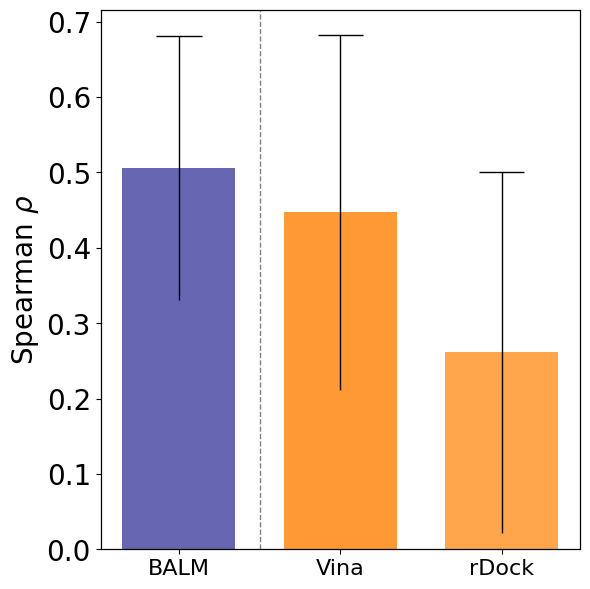

In [64]:
# Plot Spearman
plt.figure(figsize=(6,6))
bars = plt.bar(plot_data['Model'], plot_data['Spearman'], color=colors, width=bar_width)

# Set y-axis label
plt.ylabel(r'Spearman $\rho$', fontsize=20)

# Add manual error bars with only the top cap
for bar, std in zip(bars, plot_data['Spearman Std']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.errorbar(x=x, y=y, yerr=std, fmt='none', color='black', lw=1, capsize=0)
    plt.hlines(y=y + std, xmin=x - bar.get_width() * 0.2, xmax=x + bar.get_width() * 0.2, color='black', lw=1)


plt.axvline(0.5, color='grey', linestyle='--', linewidth=1)
plt.xticks(fontsize=16, ha='center')
plt.yticks(fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.9)

plt.tight_layout()
plt.savefig(os.path.join('plots', 'spearman_bar.png'), dpi=500)
plt.show()

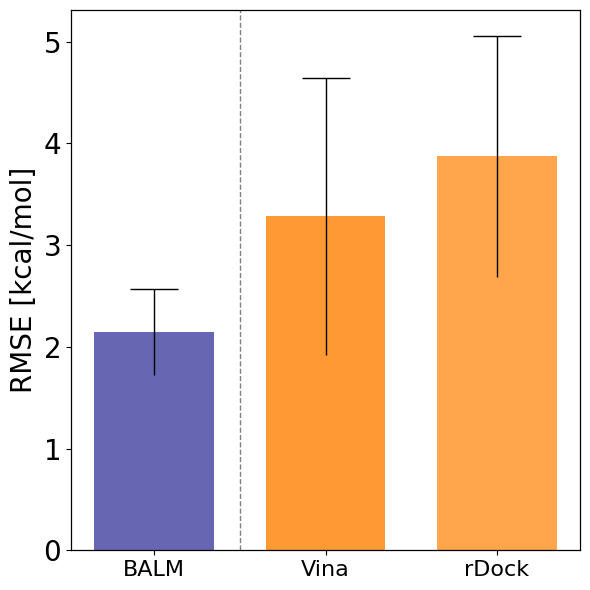

In [65]:
# Plot RMSE
plt.figure(figsize=(6, 6))
bars = plt.bar(plot_data['Model'], plot_data['RMSE'], color=colors, width=bar_width)

# Set y-axis label
plt.ylabel(r'RMSE [kcal/mol]', fontsize=20)

# Add manual error bars with only the top cap
for bar, std in zip(bars, plot_data['RMSE Std']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.errorbar(x=x, y=y, yerr=std, fmt='none', color='black', lw=1, capsize=0)
    plt.hlines(y=y + std, xmin=x - bar.get_width() * 0.2, xmax=x + bar.get_width() * 0.2, color='black', lw=1)


plt.axvline(0.5, color='grey', linestyle='--', linewidth=1)
plt.xticks(fontsize=16, ha='center')
plt.yticks(fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.9)

plt.tight_layout()
plt.savefig(os.path.join('plots', 'rmse_bar.png'), dpi=500)
plt.show()
